# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
import time

/netapp/home/mincheol/anaconda3/envs/scvi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.decomposition import PCA

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
import sys
sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')
import scme

In [7]:
data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/'

### Perform some basic filtering

In [8]:
adata = sc.read(data_path + 'interferon.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [9]:
adata.obs.cell.value_counts()

CD4 T cells          10373
CD14+ Monocytes       5355
B cells               2570
CD8 T cells           2039
NK cells              1991
FCGR3A+ Monocytes     1592
Dendritic cells        432
Megakaryocytes         208
Name: cell, dtype: int64

In [10]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

saving figure to file ./figures/tsne_all_ct.png


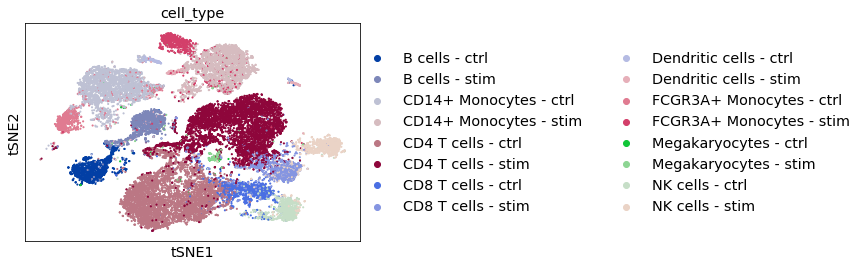

In [11]:
sc.pl.tsne(adata, color='cell_type', save='_all_ct.png')

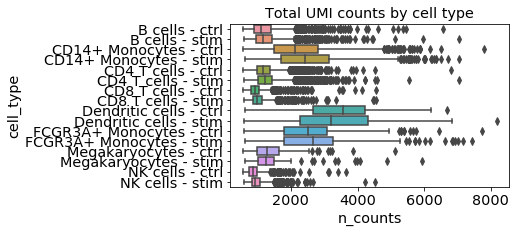

In [12]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
plt.title('Total UMI counts by cell type')
plt.savefig('celltype_numi.pdf')
plt.savefig('celltype_numi.png')

In [13]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1880


In [14]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    plt.hist(x[condition], **kwargs)

### HT testing

In [233]:
adata_cd4 = adata[adata.obs.cell == 'C4'].copy()

In [239]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata_cd4, 
    group_label='stim',
    n_umis_column='n_counts',
    num_permute=50000,
    beta=0.1)

In [244]:
%%time
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: ctrl
Computing observed moments for: stim
CPU times: user 1.63 s, sys: 4.07 ms, total: 1.64 s
Wall time: 1.63 s


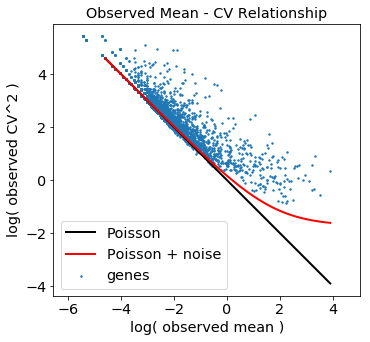

In [243]:
estimator.plot_cv_mean_curve()

In [225]:
estimator.estimate_parameters()

In [226]:
estimator.estimated_central_moments['stim']['second'][1030]

131.87090480356937

In [227]:
estimator.parameters['ctrl']['corr'][0, 1030]

0.25650143225937977

In [228]:
estimator.observed_moments['stim']['second'][1030]

10.732374691404058

In [229]:
estimator.observed_central_moments['stim']['first'][1030]

2.4305596

In [230]:
np.where((estimator.estimated_central_moments['stim']['second'] < 0))[0]

array([], dtype=int64)

In [231]:
adata.var.index[np.where((estimator.estimated_central_moments['stim']['second'] < 0))[0]]

Index([], dtype='object', name='index')

In [232]:
2.4305596 - estimator.beta_sq/estimator.beta*2.4305596 - 10.732374691404058

-8.590955965075555

In [169]:
-estimator.beta_sq

-0.015550363106923553

In [179]:
(-8.679775934734247)/(-0.015550363106923553) - (2.4305596**2)/0.01

-32.59008317580526

In [172]:
adata_cd4[adata_cd4.obs['stim'] == 'stim'].X[:, 1030]

<5219x1 sparse matrix of type '<class 'numpy.float32'>'
	with 4303 stored elements in Compressed Sparse Row format>

In [142]:
%%time
estimator.compute_confidence_intervals_2d(
    gene_list_1=['IRF8', 'HES4'],
    gene_list_2=['IFIT3', 'OASL'],
    groups=['ctrl', 'stim'])

Gamma RVs generated..
CPU times: user 4.14 s, sys: 1.86 s, total: 6.01 s
Wall time: 6.01 s


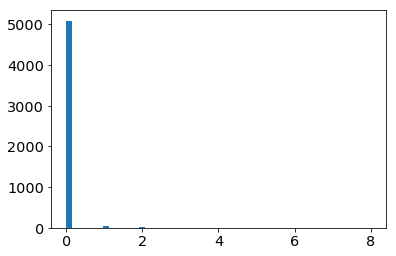

In [190]:
plt.hist(adata_cd4[adata_cd4.obs['stim'] == 'ctrl'].X[:, 1031].toarray(), bins=50);

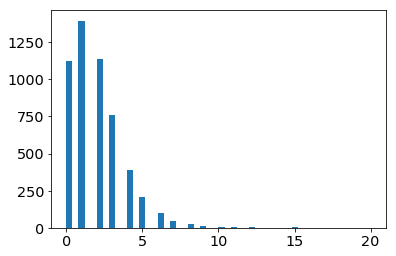

In [191]:
plt.hist(adata_cd4[adata_cd4.obs['stim'] == 'stim'].X[:, 1031].toarray(), bins=50);

In [ ]:
estimator.observed_moments['stim']['second'][1030]

In [163]:
estimator.estimated_central_moments['stim']['second'][1030]

-32.32669005350101

In [161]:
estimator.estimated_central_moments['stim']['second'][1030]

-32.32669005350101

In [153]:
estimator.parameters['stim']['corr'][0, 1030]

nan

In [157]:
estimator.parameters['stim']['log_mean'][1030]

3.1907065

In [ ]:
estimator.parameters['stim']['log_residual_var'][1030]

In [158]:
estimator.parameters['stim']['log_residual_var'][1030]

nan

In [156]:
estimator.parameters['stim']['mean'][1030]

24.305595

In [147]:
estimator.hypothesis_test_result_2d[('ctrl', 'stim')]


{'dc_diff': matrix([[        nan,  0.09494802],
         [        nan, -0.14561598]]), 'dc_pval': array([[nan,  0.],
        [nan,  0.]]), 'dc_fdr': array([[1., 0.],
        [1., 0.]]), 'gene_idx_1': array([1524,    0]), 'gene_idx_2': array([1030, 1266])}

In [144]:
estimator.hypothesis_test_result_2d[('ctrl', 'stim')]['dc_diff']

matrix([[        nan,  0.09494802],
        [        nan, -0.14561598]])

In [120]:
%%time
estimator.compute_confidence_intervals_1d(groups=['ctrl', 'stim'])

KeyboardInterrupt: 

In [28]:
%%time
estimator.compute_confidence_intervals_1d(groups=['ctrl', 'stim'])

Gamma RVs generated..
CPU times: user 4min 21s, sys: 31.9 s, total: 4min 53s
Wall time: 4min 53s


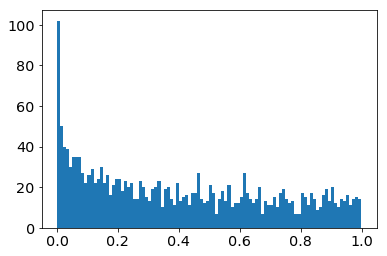

In [35]:
robust_hist(estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['dv_pval'], bins=100)

In [36]:
adata.var.head(5)

,gene_ids,n_cells
index,,
HES4,ENSG00000188290,2316
TNFRSF18,ENSG00000186891,1185
TNFRSF4,ENSG00000186827,1076
SDF4,ENSG00000078808,1868
CPSF3L,ENSG00000127054,1135


In [31]:
estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['de_pval']

array([0.     , 0.23736, 0.03116, ..., 0.09664, 0.     , 0.40064])

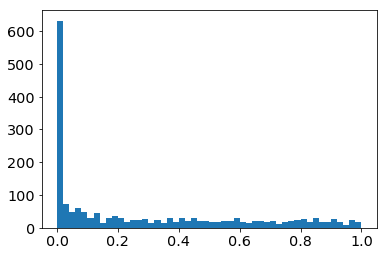

In [30]:
robust_hist(estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['de_fdr'], bins=50)

### Observed $\mu$-$CV^{2}$ Relationship

In [884]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [1166]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [1167]:
estimator.estimate_beta_sq(tolerance=5)

Computing observed moments for: CD14+ Monocytes
Computing observed moments for: CD4 T cells
Computing observed moments for: Dendritic cells
Computing observed moments for: NK cells
Computing observed moments for: CD8 T cells
Computing observed moments for: B cells
Computing observed moments for: Megakaryocytes
Computing observed moments for: FCGR3A+ Monocytes


In [1168]:
estimator.noise_level

0.31200192389783155

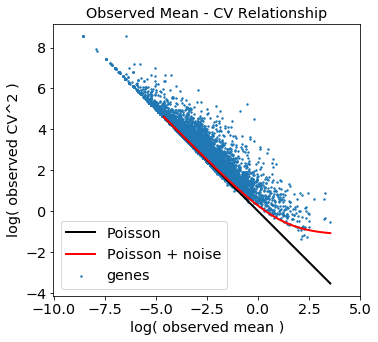

In [1169]:
estimator.plot_cv_mean_curve()

### Estimated $\mu$-$CV^2$ Relationship

In [1147]:
observed_mean = estimator.observed_moments[ct]['first']
observed_var = estimator.observed_moments[ct]['second'] - observed_mean**2
observed_disp = observed_var/observed_mean
observed_cv_sq = observed_var / observed_mean**2

est_mean = np.concatenate([estimator.estimated_central_moments[ct]['first'] for ct in estimator.groups])
est_var = np.concatenate([estimator.estimated_central_moments[ct]['second'] for ct in estimator.groups])
est_disp = est_var/est_mean
est_cv = est_var/est_mean**2

Text(0,0.5,'log( estimated true CV^2 )')

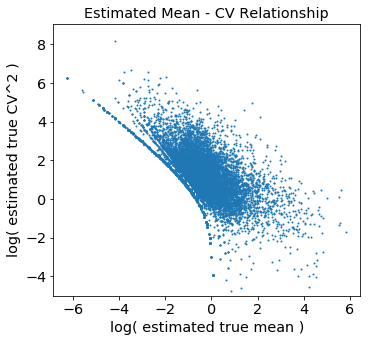

In [1150]:
plt.figure(figsize=(5.5, 5))

plt.scatter(
    np.log(est_mean),
    np.log(est_cv),
    s=1)
plt.ylim(-5,)
plt.title('Estimated Mean - CV Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( estimated true CV^2 )')

### Residual variance

[0.01903997 0.00655485 0.00499026 ... 0.10718361 0.03799471 0.17059255]


Text(0,0.5,'log( estimated true variance )')

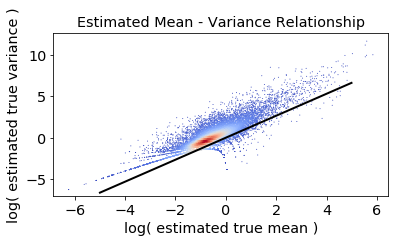

In [1149]:
plt.figure(figsize=(6, 3))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var),
    s=1, 
    cmap='coolwarm')
x_fit = np.arange(-5, 5, 0.01)
y_fit = x_fit*1.3243502622902206
plt.plot(x_fit, y_fit, color='k', lw=2)
plt.ylim(-7,)
plt.title('Estimated Mean - Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( estimated true variance )')

[0.01903997 0.00655485 0.00499026 ... 0.10718361 0.03799471 0.17059256]


Text(0,0.5,'log( residual variance )')

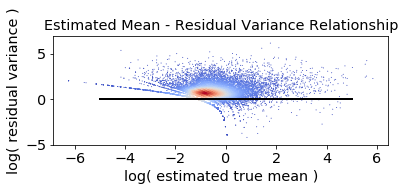

In [1145]:
plt.figure(figsize=(6, 2))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var) - 1.3243502622902206*np.log(est_mean),
    s=1, 
    cmap='coolwarm')
plt.plot([-5, 5], np.array([0, 0]), color='k', lw=2)
plt.ylim(-5,)
plt.title('Estimated Mean - Residual Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( residual variance )')

### Cell type markers

In [1178]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [1184]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [1185]:
estimator.estimate_beta_sq(tolerance=5)

Computing observed moments for: CD14+ Monocytes
Computing observed moments for: CD4 T cells
Computing observed moments for: Dendritic cells
Computing observed moments for: NK cells
Computing observed moments for: CD8 T cells
Computing observed moments for: B cells
Computing observed moments for: Megakaryocytes
Computing observed moments for: FCGR3A+ Monocytes


In [1186]:
estimator.estimate_parameters()

In [1187]:
for ct in adata_ctrl.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.hypothesis_test_1d('-' + ct, ct)
    upreg_stats, upreg_genes = estimator.get_increased_exp_genes('-' + ct, ct, num_genes=25)
    
    print(upreg_genes)
    
    break

Calculating stats for CD14+ Monocytes


AttributeError: 'SingleCellEstimator' object has no attribute 'get_increased_exp_genes'

## Effect of interferon stimulation across cell types

### Perform hypothesis testing, get deltas in log(mean) and log(dispersion)

In [196]:
for ct in adata.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    
    estimator.hypothesis_test_1d(ct + ' - ctrl', ct + ' - stim')
    
    break

Calculating stats for CD14+ Monocytes
Calculating stats for CD4 T cells
Calculating stats for Dendritic cells
Calculating stats for NK cells
Calculating stats for CD8 T cells
Calculating stats for B cells
Calculating stats for Megakaryocytes
Calculating stats for FCGR3A+ Monocytes


In [197]:
key = frozenset(['CD4 T cells - ctrl', 'CD4 T cells - stim'])

In [200]:
mean_delta = estimator.hypothesis_test_result_1d[key]['de_diff']
disp_delta = estimator.hypothesis_test_result_1d[key]['dv_diff']

In [ ]:
cutoff = 0.1

In [ ]:
de_sig = estimator.hypothesis_test_result_1d[key]['de_fdr'] < cutoff
dv_sig = estimator.hypothesis_test_result_1d[key]['dv_fdr'] < cutoff


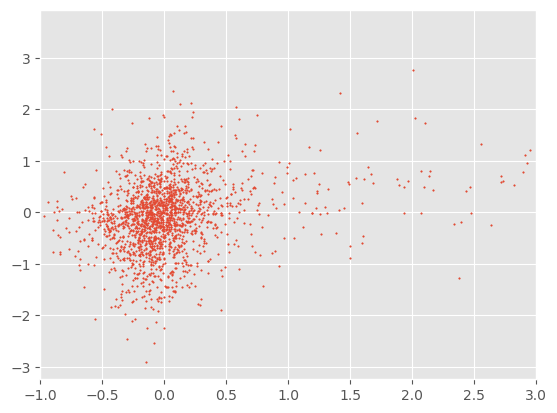

In [206]:
plt.scatter(mean_delta, disp_delta, s=1);
plt.xlim(-1, 3);

In [520]:
upreg_genes_dict = {}
downreg_genes_dict = {}
inc_var_genes_dict = {}
dec_var_genes_dict = {}
only_inc_var_genes_dict = {}
only_dec_var_genes_dict = {}
only_upreg_genes_dict = {}
for ct in adata_ctrl.obs.cell.drop_duplicates():
    
    print('Calculating stats for {}'.format(ct))
    upreg_stats, upreg_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'mean', 'increase',
        num_genes=10000, sig=0.15)
    downreg_stats, downreg_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'mean', 'decrease',
        num_genes=10000, sig=0.15)
    inc_var_stats, inc_var_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'dispersion', 'increase',
        num_genes=10000, sig=0.15)
    dec_var_stats, dec_var_genes = estimator.get_differential_genes(
        ct + ' - ctrl', ct + ' - stim', 'dispersion', 'decrease',
        num_genes=10000, sig=0.15)
    upreg_genes_dict[ct] = upreg_genes
    downreg_genes_dict[ct] = downreg_genes
    inc_var_genes_dict[ct] = inc_var_genes
    dec_var_genes_dict[ct] = dec_var_genes
    only_inc_var_genes_dict[ct] = list(set(inc_var_genes) - set(upreg_genes) - set(downreg_genes))
    only_upreg_genes_dict[ct] = list(set(upreg_genes) - set(inc_var_genes))
    only_dec_var_genes_dict[ct] = list(set(dec_var_genes) - set(upreg_genes) - set(downreg_genes))

dec_genes = set()
for key, genes in dec_var_genes_dict.items():
    dec_genes |= set(genes)
inc_genes = set()
for key, genes in inc_var_genes_dict.items():
    inc_genes |= set(genes)
    

Calculating stats for CD14+ Monocytes
Calculating stats for CD4 T cells
Calculating stats for Dendritic cells
Calculating stats for NK cells
Calculating stats for CD8 T cells
Calculating stats for B cells
Calculating stats for Megakaryocytes
Calculating stats for FCGR3A+ Monocytes


In [ ]:
print(upreg_genes_dict)
print(downreg_genes_dict)
print(inc_var_genes_dict)
print(dec_var_genes_dict)

### Expression changes across CT for a gene

In [567]:
def plot_exp_changes_across_ct(gene, estimator, barwidth=0.3):
    
    plt.figure(figsize=(11, 6))
    
    plt.subplots_adjust(hspace=0.1)
    
    groups = estimator.anndata.obs['cell'].drop_duplicates()
    
    labels = estimator.anndata.obs['cell'].drop_duplicates()
    labels = [label.replace(' ', '\n') for label in labels]
    labels[-2] = 'Megaka\nryocytes'
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    ctrl_means = np.array([estimator.parameters[group + ' - ctrl']['mean'][gene_idx] for group in groups])
    stim_means = np.array([estimator.parameters[group + ' - stim']['mean'][gene_idx] for group in groups])
    ctrl_means_ci = np.array([estimator.parameters_confidence_intervals[group + ' - ctrl']['log1p_mean'][gene_idx] for group in groups])
    stim_means_ci = np.array([estimator.parameters_confidence_intervals[group + ' - stim']['log1p_mean'][gene_idx] for group in groups])
    
    ctrl_vars = np.array([estimator.parameters[group + ' - ctrl']['dispersion'][gene_idx] for group in groups])
    stim_vars = np.array([estimator.parameters[group + ' - stim']['dispersion'][gene_idx] for group in groups])
    ctrl_vars_ci = np.array([estimator.parameters_confidence_intervals[group + ' - ctrl']['log1p_dispersion'][gene_idx] for group in groups])
    stim_vars_ci = np.array([estimator.parameters_confidence_intervals[group + ' - stim']['log1p_dispersion'][gene_idx] for group in groups])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    
    plt.subplot(2, 1, 1)
    plt.title('{} Expression in response to IFN-B'.format(gene))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width=barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width=barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 1)
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width=barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width=barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1)
    plt.ylabel('Log(dispersion+1)')

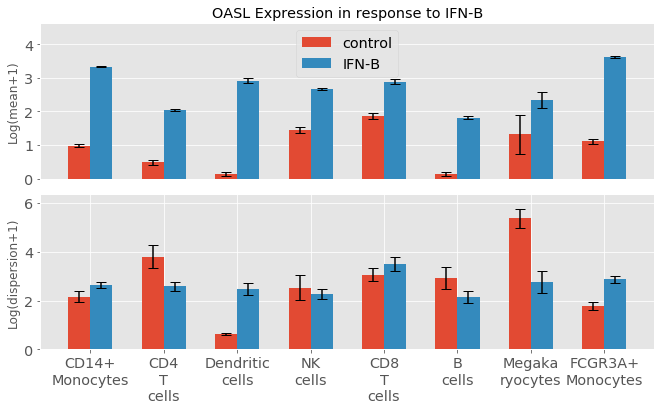

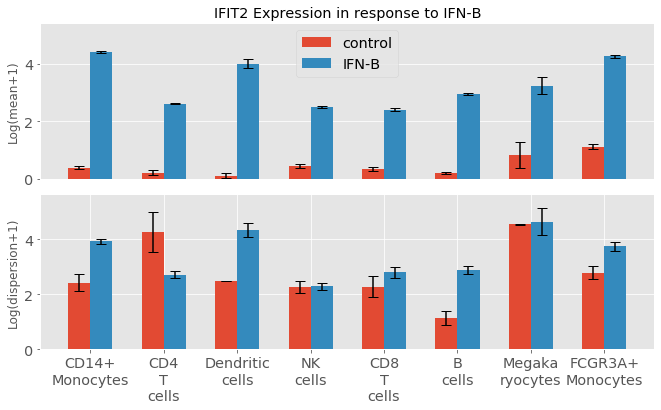

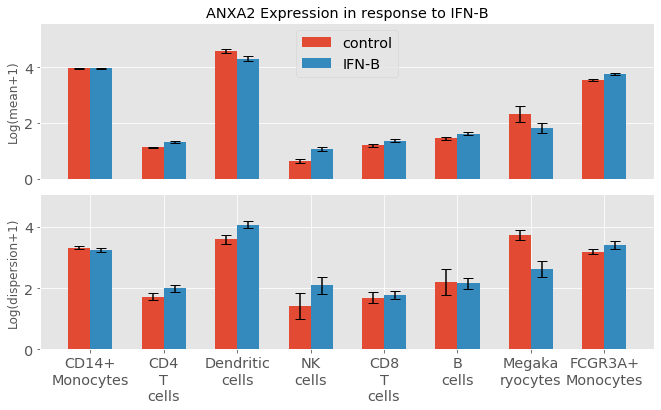

In [583]:
for gene in ['OASL', 'IFIT2', 'ANXA2']:
    plot_exp_changes_across_ct(gene, estimator)
    plt.savefig('{}_across_ct.pdf'.format(gene))
    plt.savefig('{}_across_ct.png'.format(gene))

### Expression changes across different genes for a CT

In [191]:
def plot_exp_across_genes(genes, ct, barwidth=0.3):

    plt.figure(figsize=(len(genes)*1.5, 7))
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([estimator.parameters[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([estimator.parameters[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([estimator.parameters[ct + ' - ctrl']['dispersion'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([estimator.parameters[ct + ' - stim']['dispersion'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - ctrl']['log1p_dispersion'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([estimator.parameters_confidence_intervals[ct + ' - stim']['log1p_dispersion'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = genes
    
    plt.subplot(2, 1, 1)
    plt.title('Expression changes in {}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1.4)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Log(dispersion+1)')

In [192]:
genes_1 = ['PTCD3', 'CDK12', 'RAB3GAP1', 'FAS', 'SETX']
# both sig, only var sig, both sig, both sig, both sig, only var

In [193]:
genes_2 = ['IFIT1', 'IFIT2', 'IFIT3', 'IFITM3', 'IFIT5']

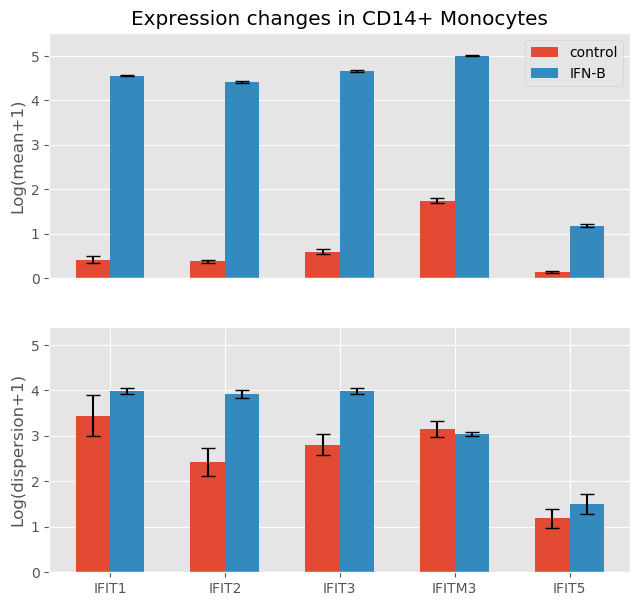

In [194]:
plot_exp_across_genes(genes_2, 'CD14+ Monocytes', barwidth=0.3)
plt.savefig('monocytes_across_ifi_genes.png')

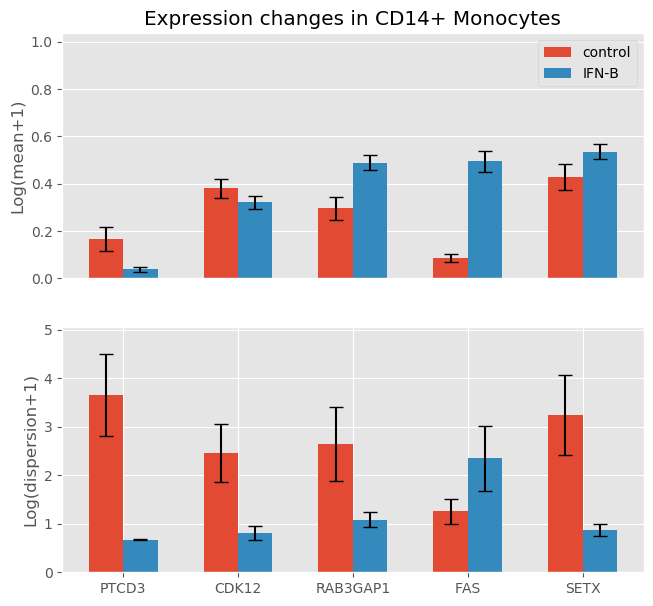

In [195]:
plot_exp_across_genes(genes_1, 'CD14+ Monocytes', barwidth=0.3)
plt.savefig('monocytes_across_other_genes.png')

### Pseudotime interferon stimulation analysis

In [313]:
cd4_pt_df = pd.read_csv(data_path + 'cd4_timepoints.csv', index_col=0)
cd4_adata = adata[adata.obs.cell == 'CD4 T cells'].copy()
cd4_adata.obs['stim_tp'] = cd4_pt_df['stim_tp'].astype(str)
cd4_stim_adata = cd4_adata[cd4_adata.obs.stim == 'stim'].copy()
cd4_stim_adata.obs['stim_tp'] = cd4_stim_adata.obs['stim_tp'].replace('5', '4')



In [314]:
imp.reload(simplesc)
stim_tp_estimator = simplesc.SingleCellEstimator(
    adata=cd4_stim_adata, 
    group_label='stim_tp',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [315]:
for tp in cd4_stim_adata.obs.stim_tp.drop_duplicates():
    
    print('Calculating stats for {}'.format(tp))
    
    stim_tp_estimator.compute_observed_moments(tp)
    stim_tp_estimator.compute_estimated_moments(tp)
    stim_tp_estimator.compute_params(tp)
    stim_tp_estimator.compute_confidence_intervals(tp)

Calculating stats for 2
Calculating stats for 0
Calculating stats for 1
Calculating stats for 3
Calculating stats for 4


In [592]:
def plot_param_trajectory(gene, estimator, x_axis_width, y_axis_width):
    
    groups = [str(i) for i in range(5)]
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    means = np.array([estimator.parameters[group]['log_mean'][gene_idx] for group in groups])
    dispersions = np.array([estimator.parameters[group]['log_dispersion'][gene_idx] for group in groups])
    
    means_ci = [estimator.parameters_confidence_intervals[group]['log_mean'][gene_idx] for group in groups]
    dispersions_ci = [estimator.parameters_confidence_intervals[group]['log_dispersion'][gene_idx] for group in groups]
    
    plt.errorbar(
        x=means, 
        y=dispersions,
        xerr=means_ci,
        yerr=dispersions_ci,
        fmt='.-',
        capsize=2,
        ecolor='k')
    plt.title(gene)
    
    offset=0.03
    for i, label in enumerate(groups):
        plt.annotate(label, (means[i], dispersions[i]+dispersions_ci[i]+offset))
    
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    
    ymid = (ymin + ymax)/2
    xmid = (xmin + xmax)/2
    
    axes.set_xlim([xmid - x_axis_width, xmid + x_axis_width])
    axes.set_ylim([ymid - y_axis_width, ymid + y_axis_width])
    
    axes.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    
    

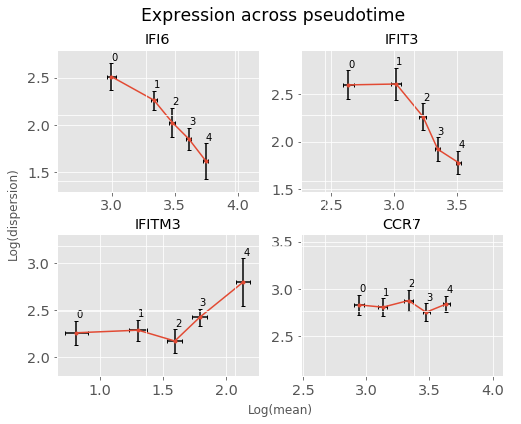

In [593]:
x_width = 0.8
y_width = 0.75
fig = plt.figure(figsize=(8, 6))
plt.suptitle('Expression across pseudotime')
plt.subplots_adjust(hspace=0.3, wspace=0.21)
plt.subplot(2, 2, 1)
plot_param_trajectory(
    gene='IFI6', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 2)
plot_param_trajectory(
    gene='IFIT3', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 3)
plot_param_trajectory(
    gene='IFITM3', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 4)
plot_param_trajectory(
    gene='CCR7', 
    estimator=stim_tp_estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)

ax = fig.add_subplot(111, frameon=False);
plt.tick_params(
    which='both',
    length=0,
    labelcolor='none', 
    top='off', 
    bottom='off', 
    left='off', 
    right='off');
ax.set_xlabel('Log(mean)', labelpad=10);
ax.set_ylabel('Log(dispersion)', labelpad=10);
plt.savefig('pseudotime.pdf')
plt.savefig('pseudotime.png')

### Differential correlation

In [113]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [236]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [237]:
ct_1 = 'Dendritic cells'
ct_2 = 'Megakaryocytes'

In [238]:
estimator.compute_observed_moments(ct_1)
estimator.compute_estimated_moments(ct_1)
estimator.compute_params(ct_1)


In [239]:
estimator.compute_observed_moments(ct_2)
estimator.compute_estimated_moments(ct_2)
estimator.compute_params(ct_2)


In [240]:
%%time
estimator.hypothesis_test_2d(ct_1, ct_2, ['CST7', 'IL8'], ['ID3', 'ANXA2'])

0.08774614334106445
0.1759331226348877
0.17682409286499023
0.29093503952026367
0.2918050289154053
------
0.2517881393432617
0.519766092300415
0.525015115737915
0.8669891357421875
0.8679690361022949
------
0.6348316669464111
1.4870448112487793
1.4879648685455322
2.8112969398498535
2.812116861343384
------
1.053415060043335
2.5744659900665283
2.5751819610595703
5.131809949874878
5.13249397277832
------
CPU times: user 6.67 s, sys: 2.83 s, total: 9.5 s
Wall time: 9.32 s


In [235]:
%%time
estimator.hypothesis_test_2d(ct_1, ct_2, ['CST7', 'IL8'], ['ID3', 'ANXA2'])

0.0717158317565918
0.19289302825927734
0.19494009017944336
0.3053410053253174
0.3062911033630371
------
0.25130605697631836
0.616260290145874
0.61971116065979
0.9411211013793945
0.941824197769165
------
0.631676197052002
1.9707250595092773
1.9716112613677979
3.3119101524353027
3.313019037246704
------
1.1251001358032227
4.058524131774902
4.059325933456421
6.766273021697998
6.766947984695435
------
CPU times: user 8.39 s, sys: 3.2 s, total: 11.6 s
Wall time: 11.5 s


In [220]:
estimator.hypothesis_test_result_2d[frozenset([ct_1, ct_2])]

{'dc_diff': matrix([[ 0.00560849, -0.53431162],
         [-0.09998574,  0.18945053]]),
 'gene_idx_1': array([1689,  464]),
 'gene_idx_2': array([  21, 1426]),
 'dc_pval': array([[7.726e-01, 4.000e-04],
        [3.587e-01, 1.109e-01]]),
 'dc_fdr': array([[0.7726    , 0.0016    ],
        [0.47826667, 0.2218    ]])}